In [50]:
'''
Module containing advection3 and, in time advection and advection2
'''
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import numpy as np

def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 1000
    u = 20
    dt = 0.45* dx/ u
    Numpoints = 290
    shift = Numpoints/5 
    c_0 = 1
    alpha = 0.01
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix = np.zeros((timesteps+1, Numpoints+4))
    cmatrix[0, 2:Numpoints+2]= c_0 * np.exp(- alpha * (np.arange(0,Numpoints)* dx -shift * dx)**2)
    
# set the boundary points
    cmatrix = boundary_conditions(cmatrix, 0, Numpoints)

    return dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[time, 0] = cmatrix[time, Numpoints-1]
    cmatrix[time, 1] = cmatrix[time, Numpoints]
    cmatrix[time, Numpoints+2] = cmatrix[time, 3]
    cmatrix[time, Numpoints+3] = cmatrix[time, 4]

    return cmatrix

def advect3_gettable(order, Numpoints):
    
    '''read in the corresponding coefficient table for the calculation of coefficients for advection3
    '''

# create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))

    fname = 'Tables/l{0}_table.txt'.format(order)
    fp = open(fname, 'r')
 
    for i in range(order+1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :]= temp
        
    fp.close()
    return ltable

def step_advect(timesteps, cmatrix, Numpoints, u, dt, dx):
    '''Step algorithm for the Central Scheme'''
    for timecount in range(0, timesteps):

        cmatrix[timecount+1, 2:Numpoints+2]= cmatrix[timecount, 2:Numpoints+2] - (
            u * dt/(2* dx) * (cmatrix[timecount, 3:Numpoints+3] - cmatrix[timecount, 1:Numpoints+1]))

        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)
    return cmatrix

def step_advect2(timesteps, cmatrix, Numpoints, u, dt, dx):
    '''Step algorithm for Upstream Scheme'''

    for timecount in range(0, timesteps):

        cmatrix[timecount+1, 2:Numpoints + 2]= cmatrix[timecount, 2:Numpoints+2] - (
            u * dt/ dx * (cmatrix[timecount, 2:Numpoints+2] - cmatrix[timecount, 1:Numpoints+1]))

        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)
    return cmatrix

    
def step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon):
    '''Step algorithm for Bott Scheme'''
    
# create a matrix to store the current coefficients a(j, k)
    amatrix = np.zeros((order+1, Numpoints))
    
    for timecount in range(0,timesteps):
        for base in range(0,5):
            amatrix[0:order+1, 0:Numpoints] += np.dot(
                ltable[0:order+2, base:base+1], 
                cmatrix[timecount:timecount+1, 0+base:Numpoints+base])

# calculate I of c at j+1/2 , as well as I at j
# as these values will be needed to calculate i at j+1/2 , as
# well as i at j
    
# calculate I of c at j+1/2(Iplus), 
# and at j(Iatj)
        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue= 1 - 2*u*dt/dx
        for k in range(order+1):
            Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
            Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)
    
# finally, calculate the current concentration 
        cmatrix[timecount+1, 3:Numpoints+2] = (
            cmatrix[timecount, 3:Numpoints+2] * 
            (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
             cmatrix[timecount, 2:Numpoints+1]* 
             Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])
               
# set the boundary condition at the first point
        cmatrix[timecount+1, 2]= cmatrix[timecount+1, Numpoints+1]
# set the other boundary points
        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)

    return cmatrix

def make_graph(cmatrix, timesteps, Numpoints, dt):
    """Create graphs of the model results using matplotlib.
    """

    # Create a figure with size 15, 5
    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    # Set the figure title, and the axes labels.
    the_title = fig.text(0.25, 0.95, 'Concentrations Results from t = %.3fs to %.3fs' % (0, dt*timesteps))
    ax.set_ylabel('Concentration')
    ax.set_xlabel('Grid Point')

    # We use color to differentiate lines at different times.  Set up the color map
    cmap = plt.get_cmap('spectral')
    cNorm  = colors.Normalize(vmin=0, vmax=1.*timesteps)
    cNorm_inseconds = colors.Normalize(vmin=0, vmax=1.*timesteps*dt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # Only try to plot 20 lines, so choose an interval if more than that (i.e. plot
    # every interval lines
    interval = np.int(np.ceil(timesteps/20))

    # Do the main plot
    for time in range(0, timesteps, interval):
        colorVal = scalarMap.to_rgba(time)
        ax.plot(cmatrix[time, :], color=colorVal)

    # Add the custom colorbar
    ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
    cb1 = colorbar.ColorbarBase(ax2, cmap=cmap, norm=cNorm_inseconds)
    cb1.set_label('Time (s)')
    return

def advection(timesteps):
    '''Entry point for the Central Scheme'''
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    cmatrix = step_advect(timesteps, cmatrix, Numpoints, u, dt, dx)
    make_graph(cmatrix, timesteps, Numpoints, dt)

def advection2(timesteps):
    '''Entry point for the Upstream Scheme'''
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    cmatrix = step_advect2(timesteps, cmatrix, Numpoints, u, dt, dx)
    make_graph(cmatrix, timesteps, Numpoints, dt)

def advection3(timesteps, order):
    ''' Entry point for the Bott Scheme'''
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    ltable = advect3_gettable(order, Numpoints)
    cmatrix = step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon)
    make_graph(cmatrix, timesteps, Numpoints, dt)  

    

Problem 1

Parameters:

a)Run program for different orders of approximating polynomials (up to 4) and compare accuracy

For oder 0

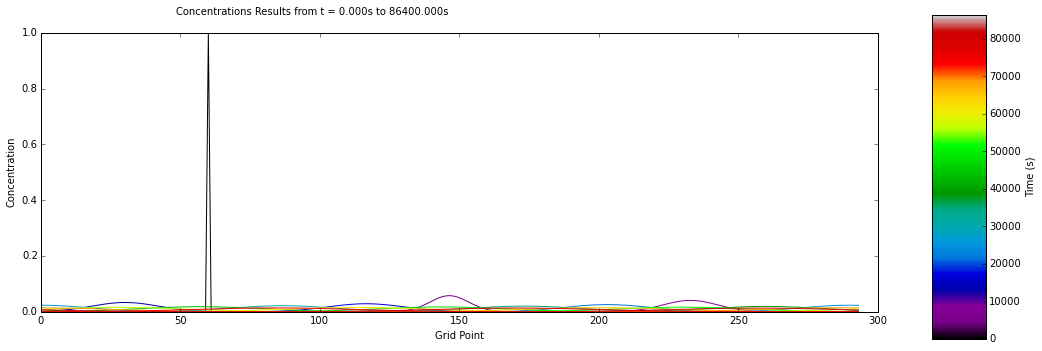

In [51]:
%matplotlib inline
advection3(3840,0)

For order 1

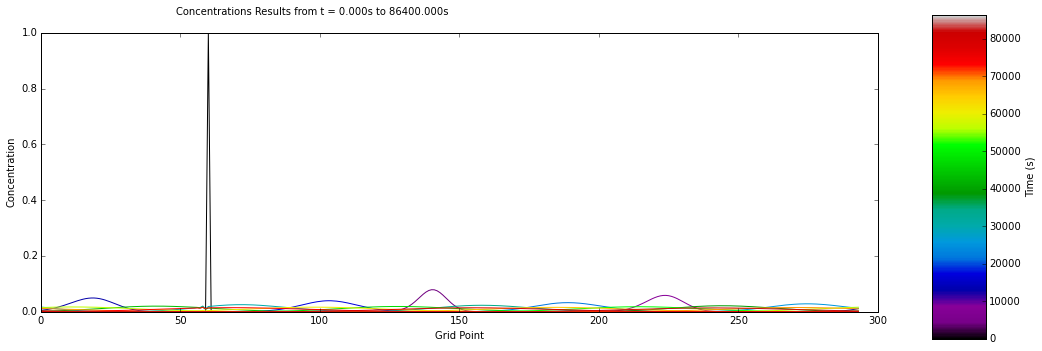

In [52]:
advection3(3840,1)

For order 2

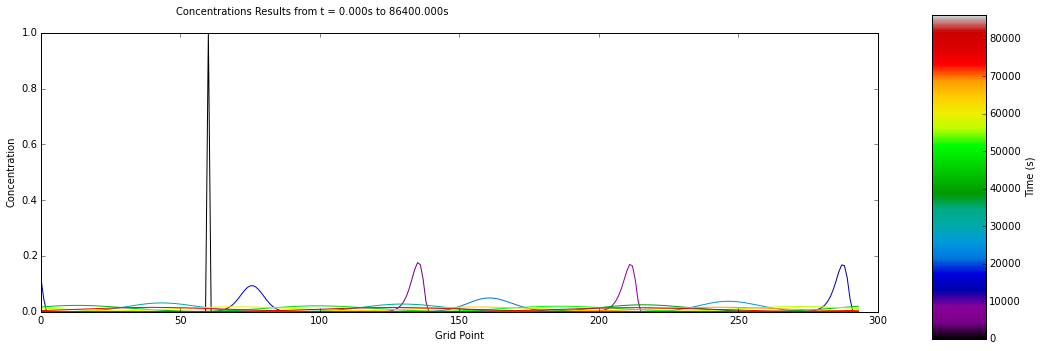

In [53]:
advection3(3840,2)

For order 3

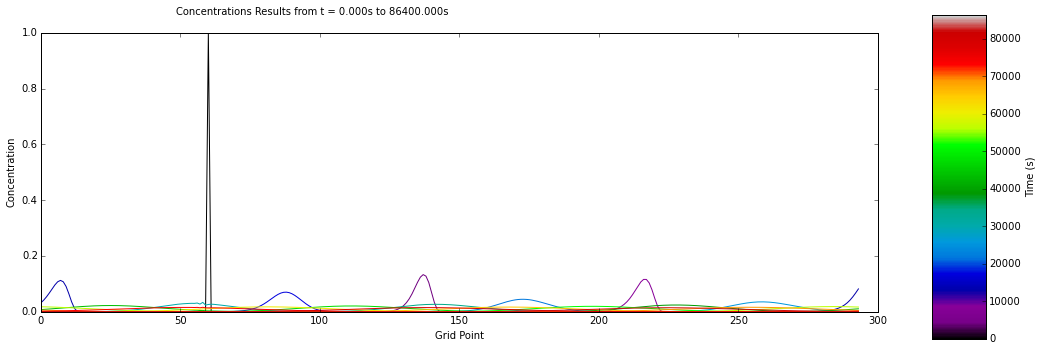

In [54]:
advection3(3840,3)

For order 4

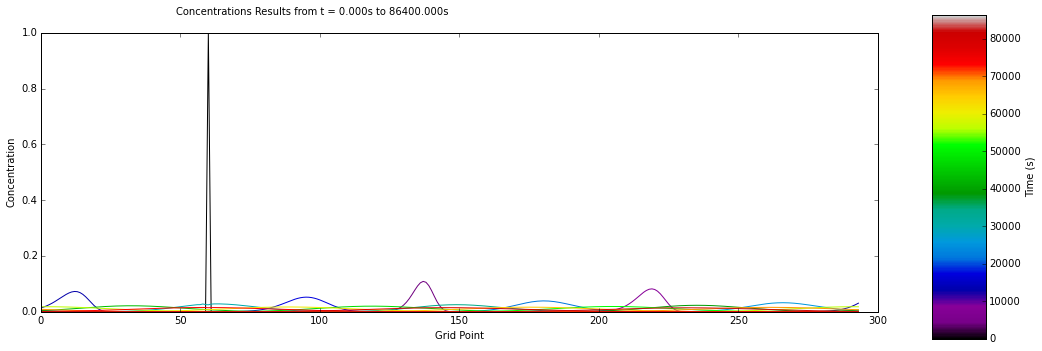

In [55]:
advection3(3840,4)

For this case, with the order increasing from 0 to 2, the maximum concentration increases and therefore the accuracy of solution increases. But when the order continues to increase, the accuracy of solution does not increase and seems to decrease.

b)Use different representations of $a_{j,k}$ for order 1 and 3, respectively.

In [56]:
'''
Module containing advection3 and, in time advection and advection2
'''
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import numpy as np

def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 1000
    u = 20
    dt = 0.45* dx/ u
    Numpoints = 290
    shift = Numpoints/5 
    c_0 = 1
    alpha = 0.01
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix = np.zeros((timesteps+1, Numpoints+4))
    cmatrix[0, 2:Numpoints+2]= c_0 * np.exp(- alpha * (np.arange(0,Numpoints)* dx -shift * dx)**2)
    
# set the boundary points
    cmatrix = boundary_conditions(cmatrix, 0, Numpoints)

    return dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[time, 0] = cmatrix[time, Numpoints-1]
    cmatrix[time, 1] = cmatrix[time, Numpoints]
    cmatrix[time, Numpoints+2] = cmatrix[time, 3]
    cmatrix[time, Numpoints+3] = cmatrix[time, 4]

    return cmatrix

def advect3_gettable(order, Numpoints):
    
    '''read in the corresponding coefficient table for the calculation of coefficients for advection3
    '''

# create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))

    fname = 'Tables/l{0}left_table.txt'.format(order)
    fp = open(fname, 'r')
 
    for i in range(order+1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :]= temp
        
    fp.close()
    return ltable

def step_advect(timesteps, cmatrix, Numpoints, u, dt, dx):
    '''Step algorithm for the Central Scheme'''
    for timecount in range(0, timesteps):

        cmatrix[timecount+1, 2:Numpoints+2]= cmatrix[timecount, 2:Numpoints+2] - (
            u * dt/(2* dx) * (cmatrix[timecount, 3:Numpoints+3] - cmatrix[timecount, 1:Numpoints+1]))

        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)
    return cmatrix

def step_advect2(timesteps, cmatrix, Numpoints, u, dt, dx):
    '''Step algorithm for Upstream Scheme'''

    for timecount in range(0, timesteps):

        cmatrix[timecount+1, 2:Numpoints + 2]= cmatrix[timecount, 2:Numpoints+2] - (
            u * dt/ dx * (cmatrix[timecount, 2:Numpoints+2] - cmatrix[timecount, 1:Numpoints+1]))

        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)
    return cmatrix

    
def step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon):
    '''Step algorithm for Bott Scheme'''
    
# create a matrix to store the current coefficients a(j, k)
    amatrix = np.zeros((order+1, Numpoints))
    
    for timecount in range(0,timesteps):
        for base in range(0,5):
            amatrix[0:order+1, 0:Numpoints] += np.dot(
                ltable[0:order+2, base:base+1], 
                cmatrix[timecount:timecount+1, 0+base:Numpoints+base])

# calculate I of c at j+1/2 , as well as I at j
# as these values will be needed to calculate i at j+1/2 , as
# well as i at j
    
# calculate I of c at j+1/2(Iplus), 
# and at j(Iatj)
        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue= 1 - 2*u*dt/dx
        for k in range(order+1):
            Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
            Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)
    
# finally, calculate the current concentration 
        cmatrix[timecount+1, 3:Numpoints+2] = (
            cmatrix[timecount, 3:Numpoints+2] * 
            (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
             cmatrix[timecount, 2:Numpoints+1]* 
             Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])
               
# set the boundary condition at the first point
        cmatrix[timecount+1, 2]= cmatrix[timecount+1, Numpoints+1]
# set the other boundary points
        cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)

    return cmatrix

def make_graph(cmatrix, timesteps, Numpoints, dt):
    """Create graphs of the model results using matplotlib.
    """

    # Create a figure with size 15, 5
    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    # Set the figure title, and the axes labels.
    the_title = fig.text(0.25, 0.95, 'Concentrations Results from t = %.3fs to %.3fs' % (0, dt*timesteps))
    ax.set_ylabel('Concentration')
    ax.set_xlabel('Grid Point')

    # We use color to differentiate lines at different times.  Set up the color map
    cmap = plt.get_cmap('spectral')
    cNorm  = colors.Normalize(vmin=0, vmax=1.*timesteps)
    cNorm_inseconds = colors.Normalize(vmin=0, vmax=1.*timesteps*dt)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)

    # Only try to plot 20 lines, so choose an interval if more than that (i.e. plot
    # every interval lines
    interval = np.int(np.ceil(timesteps/20))

    # Do the main plot
    for time in range(0, timesteps, interval):
        colorVal = scalarMap.to_rgba(time)
        ax.plot(cmatrix[time, :], color=colorVal)

    # Add the custom colorbar
    ax2 = fig.add_axes([0.95, 0.05, 0.05, 0.9])
    cb1 = colorbar.ColorbarBase(ax2, cmap=cmap, norm=cNorm_inseconds)
    cb1.set_label('Time (s)')
    return

def advection(timesteps):
    '''Entry point for the Central Scheme'''
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    cmatrix = step_advect(timesteps, cmatrix, Numpoints, u, dt, dx)
    make_graph(cmatrix, timesteps, Numpoints, dt)

def advection2(timesteps):
    '''Entry point for the Upstream Scheme'''
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    cmatrix = step_advect2(timesteps, cmatrix, Numpoints, u, dt, dx)
    make_graph(cmatrix, timesteps, Numpoints, dt)

def advection3(timesteps, order):
    ''' Entry point for the Bott Scheme'''
    dx, u, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    ltable = advect3_gettable(order, Numpoints)
    cmatrix = step_advect3(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon)
    make_graph(cmatrix, timesteps, Numpoints, dt)  

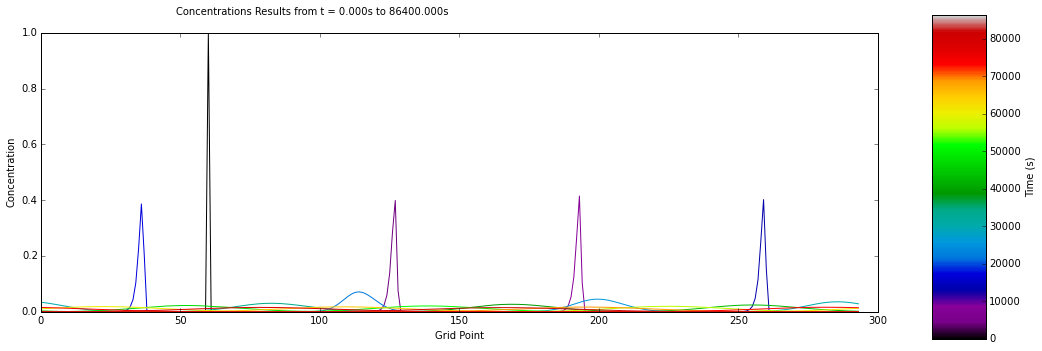

In [57]:
advection3(3840,1)

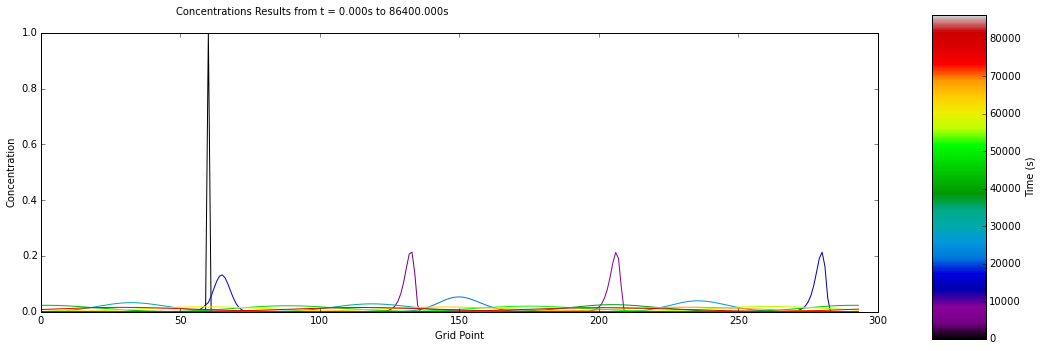

In [58]:
advection3(3840,3)

Comparing these two figures with the results in question a) with the same order, we can find these two representation behaves much better than  those in question a), especially for $l=1$

Because the wind is flowing from left to right, concentration on left will influence the values on right . And these two representations use an extran point on left side, which obeys the physics of phenomena. So they will have better accuracy than those representations that use an extra point on th.